# Работу выполнили Жилин Андрей Игоревич и Зимин Андрей Валерьевич

# Подготовка окружения
## Импорт необходимых библиотек

In [370]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt

import matplotlib.patches as mpatches

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
##from mpl_toolkits import mplot3d 
##import seaborn as sns
from sklearn.model_selection import train_test_split

## Чтение Датасета

In [371]:
df = pd.read_csv("data/iris.csv")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# 1 и 2 Задания


## Текст заданий

Текст заданий

1 Следует привести задачу классификации к бинарной. Т.е. рассматриваем
ирисы 2-х классов: Setosa и non-Setosa.


2 Из признаков оставляем только 2: sepal length и sepal width.

## Небольшие пояснения

 Во-первых, оставляем только два признака, а также выделяем variety в отдельный df, если iris-setosa, то 1, если не выполняется равенство, то -1

Запишем формально
$ \[F(x) = 
\begin{cases}

1, & \quad \text{ x is Iris-setosa} \\
-1  & \quad \text{ x is not Iris-setosa}
 
\end{cases}
\] $


## Реализация

In [372]:

y = pd.DataFrame()
X = df[["sepal_length", "sepal_width"]].to_numpy() #отбираем нужные признаки
y['variety'] = df["variety"].apply(lambda x: int(x == "Iris-setosa") - int(x != "Iris-setosa")) #функция для 1 и -1
y = y[['variety']].to_numpy() #переводим в numpy так как наш градиентный спуск работает с нампаем

## Проверки
Проверим правильно ли все 

In [373]:
X[:10, :]

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6],
       [5.4, 3.9],
       [4.6, 3.4],
       [5. , 3.4],
       [4.4, 2.9],
       [4.9, 3.1]])

In [374]:
y[10:20] #проверяем корректность

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [375]:
X.shape #проверяем корректность

(150, 2)

In [376]:
y.shape #проверяем корректность

(150, 1)

In [377]:
np.unique(y) #проверяем корректность

array([-1,  1])

## Выводы по первому и второму заданию

Импортировали данные и убедились в их корректности 

# Подготовка перед выполнением третьего задания

## Наш градиентный спуск 
наша реализация градиентного спуска с комментариями

In [378]:
class GradientDescent:
    def __init__(self, train_x, train_y, h = 0.00005, eps=0.1, start_weights=None, logging=False, min_iterations=0, strategy="package", batch_size=1, lambda_=0, seed=19): #Добавил параметр лямбда для регуляризации
        np.random.seed(seed)
        #часть за данные ааа
        self.X = train_x #тренировочная выборка
        self.y = train_y #целевой признак
        self.strategy = strategy #название стратегии(package, mini-batch или stochastic)

        #метаданные
        self.width = len(train_x[0]) + 1 #ширина тренировочной выборки
        self.height = len(train_x) #высота тренировочной выборки
        
        #модель 
        self.batch_size = batch_size
        self.min_iterations = min_iterations
        self.h = h #шаг градиентного спуска h > 0
        self.lambda_ = lambda_ #коэффициент регуляризации
        self.eps = eps #точность градиентного спуска
        self.strategies = {'package': self.step_package, 'mini-batch': self.step_mini_batch, 'stochastic': self.step_mini_batch}
        if strategy == 'stochastic':
            self.batch_size = 1
        if start_weights is None: #задание стартовых весов
            self.w = np.full(self.width, 1)
        else:
            self.w = start_weights 

        self.X = np.concatenate((np.ones(self.height).reshape(-1, 1), self.X), axis=1) #фиктивная единица
        self.q = self.calc_q() # инициализируем ошибку

        #логи
        self.logging = logging #вывод логов в консоль
        self.qs = np.array([]) #величина ошибки
        self.curr_timer = None #текущий таймер
        self.timer = np.array([]) #массив для хранения время итераций
        self.iter_num = 0 #количество итераций
        

    def start_timer(self): #засечь время
        self.curr_timer = datetime.datetime.now()
    
    def stop_timer(self): #становить и записать время
        self.timer = np.append(self.timer, np.array(datetime.datetime.now() - self.curr_timer))

    def get_time(self): #общее время выполнения программы
        return self.timer.sum()

    def get_times(self): #получить время по шагам
        return self.timer
    
    def step_package(self): #шаг пакетного градиентного спуска
        
        self.w = self.w - self.h * self.grad()  #вычисляем градиент по пакету и меняем веса

    
    def step_mini_batch(self): #шаг стохастического градиентного спуска или mini-batch зависит от размера пакета
        
        idx = np.random.randint(self.height, size=self.batch_size) # формируем индексы пакета
        self.w = self.w - self.h * self.grad(self.X[idx, :], self.y[idx, :]) #вычисляем градиент по пакету и меняем веса
        
    
    def grad(self, X = None, y = None): #вычисление градиента по пакету(подходит для mini-batch, package и stochastic)
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y

        return (X.T.dot(X.dot(self.w) - y[:, 0]))*(2/self.height)

    def fit(self): #запуск градиентного спуска
        
        q = 2*self.q

        if self.logging:
            print("Величина ошибки на каждом шаге")

        while abs(self.q - q) > self.eps or self.iter_num < self.min_iterations:
            self.start_timer()
            q = self.q #переприсваеваем значение ошибки 
            self.strategies[self.strategy]()
            self.qs = np.append(self.qs, q) #запоминаем значение ошибки
            self.q = self.calc_q() #вычисление значение ошибки после новых весов
            self.iter_num += 1
            self.stop_timer()
            if self.logging:
                print(f"Шаг {self.iter_num}: ошибка {round(self.q, int(np.log(1/self.eps)/np.log(10)))};") #логи        
        if self.logging:
            print(f"Время работы: {self.get_time().microseconds/1000:.02f} мс")
        return self.w


    def calc_q(self):
        
        return np.mean((np.dot(self.X, self.w) - self.y[:, 0]) ** 2) #вычисление ошибки

    def predict(self, X):
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.dot(X, self.w).reshape(-1, 1) #предсказание
    
    

## Наш метод опорных векторов
реализация метода опорных векторов 

Для него мы наследуемся от нашего градиентного спуска, так как почти все методы и атрибуты такие же, а те которые не подходят, мы переопределим в классе метода опорных векторов

Переопределим градиент, функцию вычисления ошибки и предсказания 

Тут должен быть вывод функции ошибки(или хотя бы расчет градиента) а так же про линейность

In [379]:

class SupportVectorMachine(GradientDescent):#наследуемся от градиентного спуска
    
    def grad(self, X = None, y = None): #переопределяем вычисление градиента для нового класса svm
        if X is None or y is None or np.size(X)==0 or np.size(y)==0:
            X = self.X
            y = self.y
        grad = np.zeros(self.width)
        for i in range(len(y)):
            if 1 - y[i]*np.dot(self.w, X[i, :]) > 0: 
                grad += -y[i] * X[i, :] # вычисление градиента
                
        return 2*self.lambda_*self.w + grad #пока написал корявый градиент пускай хотя бы так считает
    
    
    def calc_q(self): #переопределяем функцию ошибки
        loss_result = self.lambda_*((self.w**2).sum())
        for i in range(self.height):
            loss_result += max(np.array([0.0]), 1 - self.y[i]*np.dot(self.w, self.X[i, :])) #линейное ядро
        
        return loss_result[0]
    
    def predict(self, X): #переопределяем функцию предсказания
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        return np.sign(np.dot(X, self.w).reshape(-1, 1)) #предсказание
    


## Наш класс для вычисления метрик

Повторение одних и тех же действий не очень полезно, особенно в программировании, потому необходимые вычисления метрик были вынесены в отдельный класс и будут вызываться как понадобится

Отдельно можно обратить внимание на метод get_hyper_p_2_params, здесь мы получаем уравнение двумерной гиперплоскости выражая один вес через другой, можно его расширить для больших размерностей, но пока задача для двумерного аффинного пространства

Приведем простой вывод формулы гиперплоскости


$
\\ 
\text{Гиперплоскость в общем виде} \\
w_0 + w_1x_1 + w_2x_2 + \dots + w_nx_n = 0 \\
w_nx_n = - (w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}) \\
x_n = -\frac{ w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}}{w_n} \\
\text{Теперь } x_n \text{ можно переобозначить как } f(x_1, x_2, \dots, x_{n - 1})\\
f(x_1, x_2, \dots, x_{n - 1}) = -\frac{ w_0 + w_1x_1 + w_2x_2 + \dots + w_{n - 1}x_{n - 1}}{w_n} \\
$

Вот мы и получили уравнение гиперплоскости

In [380]:
class Counter:
    def __init__(self, X_train, X_test, y_train, y_test, model):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred_train = model.predict(self.X_train)
        self.y_pred_test = model.predict(self.X_test)
        self.model = model
    def plot_confusion_matrix(self, y, y_pred, label): #построение матрицы 
        cm = confusion_matrix(y, y_pred)
        print('Матрица ошибок, полученная методом confusion_matrix\n', cm)
        
        ConfusionMatrixDisplay.from_predictions(y, y_pred)
        
        plt.title(f'Матрица ошибок для {label}')
        plt.show()
    
    def calc_metrics(self, y, y_pred): #расчет всех метрик для классификации
        acc = accuracy_score(y, y_pred)
        pre = precision_score(y, y_pred)
        rec = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        print(f"accuracy: {acc}")
        print(f"precision: {pre}")
        print(f"recall: {rec}")
        print(f"f1: {f1}")
        

    def try_model(self): #построение confusion matrix и расчет метрик на тестовой и тренировочной выборках
        self.y_pred_train = self.model.predict(self.X_train)
        self.y_pred_test = self.model.predict(self.X_test)
        print("Метрики для тренировочной выборки")
        self.calc_metrics(self.y_train, self.y_pred_train)
        print()
        print('Метрики для тестовой выборки')
        self.calc_metrics(self.y_test, self.y_pred_test)
        self.plot_confusion_matrix(self.y_train, self.y_pred_train, 'тренировочной выборки')
        self.plot_confusion_matrix(self.y_test, self.y_pred_test, 'тестовой')
    

# Задание 3



## Текст задания
Выполните процедуру классификации 3 раза. В рамках данной процедуры:

 Разбейте выборку случайным образом на обучающую (100 объектов) и
тестовую.

 Проведите на обучающей выборке обучение с линейной моделью SVM и
выведите диаграмму рассеяния классов с линией гиперплоскости
разделения.

 Приведите формулу разделяющей гиперплоскости.

 Оцените точность классификации на тестовой и обучающей выборках.

## Первая модель(три в одном)

Разбиение выборки на обучающую (мы помним, что объектов 150, потому параметр тестовой части 0.33, чтобы в обучающей было 100)

In [381]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19) #устанавливаем random_state 19, чтобы не забыть эти данные


Проведите на обучающей выборке обучение с линейной моделью SVM и
выведите диаграмму рассеяния классов с линией гиперплоскости
разделения.

Мы хотим обучить тремя методами градиентного спуска и их сравнить для проведения дальнейших двух запусков

На первом запуске будем сравнивать пакетный, mini-batch и стохастический, на остальных двух будем запускать только один из них

### Пакетный градиентный спуск

In [382]:
svm = SupportVectorMachine(X_train,y_train, h=0.005, min_iterations=1000) #вызывает пакетный градиентный спуск
svm.fit()  #веса

array([ 3.08  , -3.3895,  4.837 ])


#### Уравнение разделяющей гиперплоскости


$
 \\
0.88525 - 0.974825x_1 + 1.39541x_2 = 0
$

#### Посчитаем метрики

In [383]:
cntr_svm = Counter(X_train, X_test, y_train, y_test, svm)


Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9696969696969697
f1: 0.9846153846153847

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


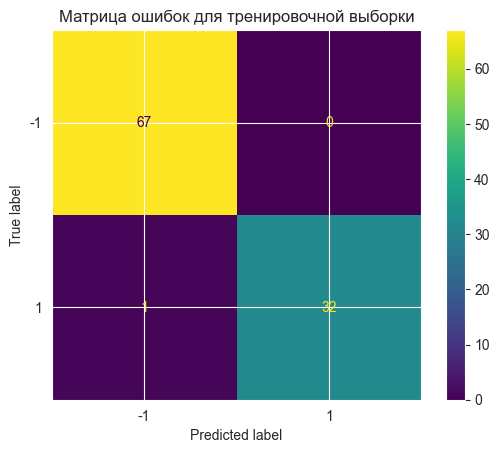

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


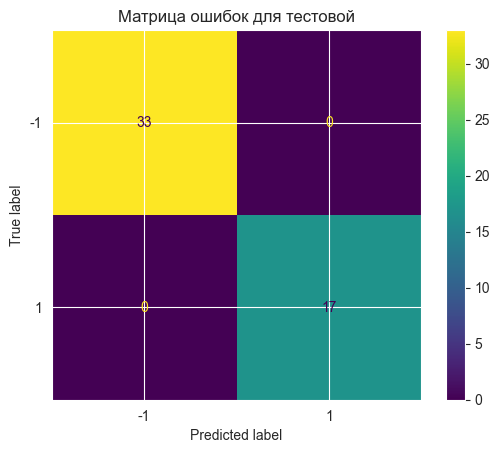

In [384]:
cntr_svm.try_model()

### mini-batch

Всё то же самое для mini batch, но у него поменяем шаг, чтобы не разошелся

In [385]:
svm_mini_batch = SupportVectorMachine(X_train, y_train, h=0.005, min_iterations=1000, strategy='mini-batch', batch_size=10) 
svm_mini_batch.fit()

array([ 1.35  , -2.0695,  3.04  ])


#### Уравнение разделяющей гиперплоскости


$
 \\
 1.35 - 2.0695x_1 + 3.04x_2 = 0
$

#### Вновь считаем метрики

Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9696969696969697
f1: 0.9846153846153847

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


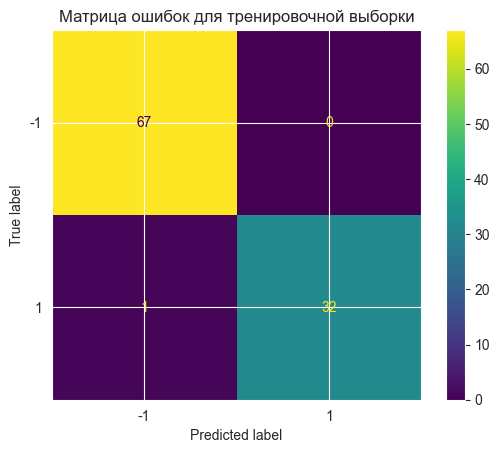

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


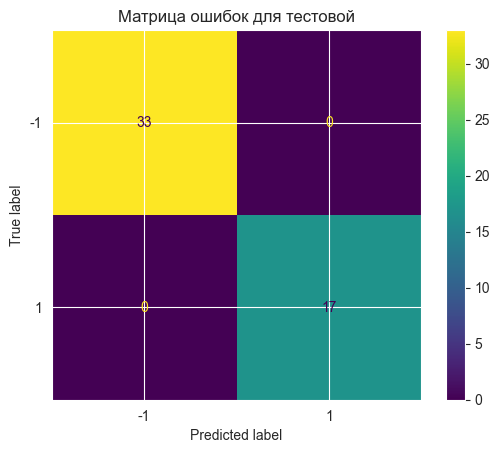

In [386]:
cntr_svm_mini_batch = Counter(X_train, X_test, y_train, y_test, svm_mini_batch)
cntr_svm_mini_batch.try_model()

### Стохастический градиентный спуск

Остался последний способ, реализованный у нас, это стохастический градиент спуск задаем те же параметры, что и у mini-batch

In [387]:
svm_stochastic = SupportVectorMachine(X_train, y_train, h=0.005, min_iterations=1000, strategy='stochastic') 
svm_stochastic.fit()

array([ 0.895 , -1.0275,  1.4475])


#### Уравнение гиперплоскости


$
 \\
0.895 - 1.0275x_1 + 1.4475x_2 = 0
$

#### Метрики для стохастического

Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9696969696969697
f1: 0.9846153846153847

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


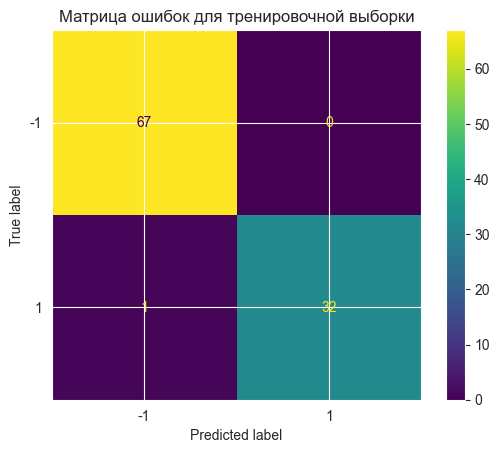

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


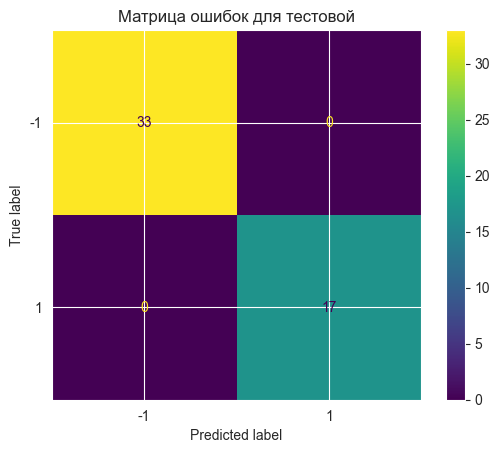

In [388]:
cntr_svm_stochastic = Counter(X_train, X_test, y_train, y_test, svm_stochastic)
cntr_svm_stochastic.try_model()

### Разделяющая гиперплоскость для всех трех

Строим гиперплоскость всех троих способов разделения

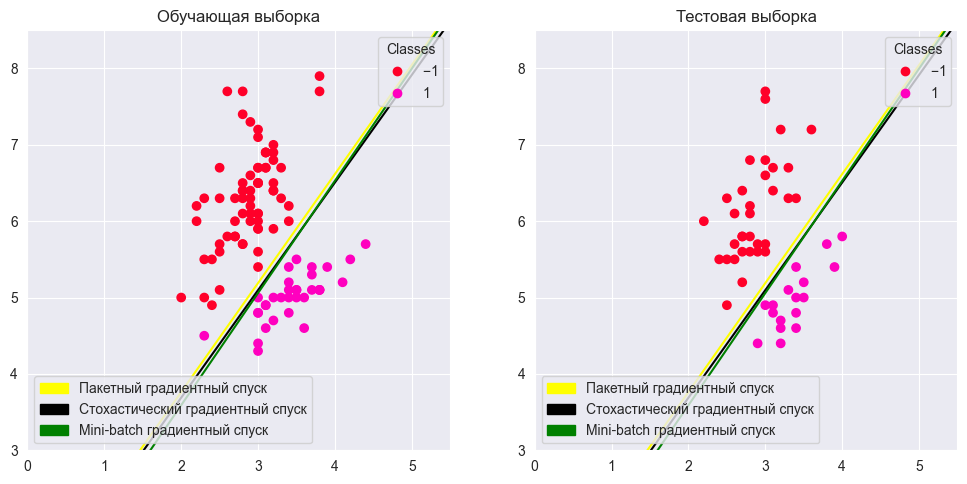

In [389]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)

svm_w = svm.w 
svm_stochastic_w = svm_stochastic.w
svm_mini_batch_w = svm_mini_batch.w

svm_z = svm_w[0] + svm_w[2] * xgrid + svm_w[1]*ygrid
svm_stochastic_z = svm_stochastic_w[0] + svm_stochastic_w[2] * xgrid + svm_stochastic_w[1]*ygrid
svm_mini_batch_z = svm_mini_batch_w[0] + svm_mini_batch_w[2] * xgrid + svm_mini_batch_w[1]*ygrid

fig = plt.figure(figsize=(12, 12))

# Обучающая выборка

ax = fig.add_subplot(221)


scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")
plt.contour(x1, x2, svm_z, colors="yellow", levels=[0])
plt.contour(x1, x2, svm_stochastic_z, colors="black", levels=[0])
plt.contour(x1, x2, svm_mini_batch_z, colors="green", levels=[0])

svm_patch = mpatches.Patch(color="yellow", label='Пакетный градиентный спуск')
svm_s_patch = mpatches.Patch(color="black", label='Стохастический градиентный спуск')
svm_m_patch = mpatches.Patch(color="green", label='Mini-batch градиентный спуск')

plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

ax.set_title('Обучающая выборка')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.legend(handles=[svm_patch, svm_s_patch, svm_m_patch])


#тестовая выборка
ax = fig.add_subplot(222)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")

plt.contour(x1, x2, svm_z, colors="yellow", levels=[0])
plt.contour(x1, x2, svm_stochastic_z, colors="black", levels=[0])
plt.contour(x1, x2, svm_mini_batch_z, colors="green", levels=[0])

svm_patch = mpatches.Patch(color="yellow", label='Пакетный градиентный спуск')
svm_s_patch = mpatches.Patch(color="black", label='Стохастический градиентный спуск')
svm_m_patch = mpatches.Patch(color="green", label='Mini-batch градиентный спуск')

plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")

ax.set_title('Тестовая выборка')
ax.add_artist(legend1)

ax.legend(handles=[svm_patch, svm_s_patch, svm_m_patch])




### Мини-выводы

По итогу метрики accuracy, precision и recall оказались одинаковыми, как следствие этого f0 тоже одинаковые

Визуально кажется, что все-таки пакетный градиентный спуск и mini-batch остается это узнать по функции ошибки 

In [390]:
print(svm.q)
print(svm_mini_batch.q)
print(svm_stochastic.q)


2.8806500000001716
6.298700000000171
15.489249999999922


### Вывод по первой модели
У пакетного меньше всего ошибка, дальше будем продолжать работать с ним

## Вторая модель(только пакетный)

Новое разбиение для новой модели

In [391]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

In [392]:
svm_2 = SupportVectorMachine(X_train,y_train,  h=0.0005, min_iterations=10000) 
svm_2.fit()  #веса

array([ 2.708  , -2.81385,  4.01575])

### Уравнение гиперплоскости 
$
 \\
0.88525 - 0.974825x_1 + 1.39541x_2 = 0
$

### Метрики

Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9696969696969697
f1: 0.9846153846153847

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[67  0]
 [ 1 32]]


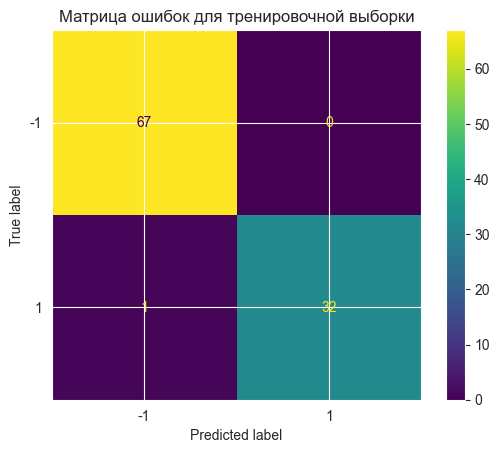

Матрица ошибок, полученная методом confusion_matrix
 [[33  0]
 [ 0 17]]


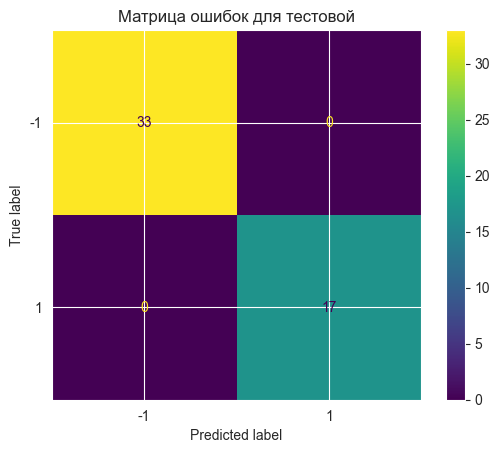

In [393]:
cntr_svm_2 = Counter(X_train, X_test, y_train, y_test, svm_2)
cntr_svm_2.try_model()

### График гиперплоскости 

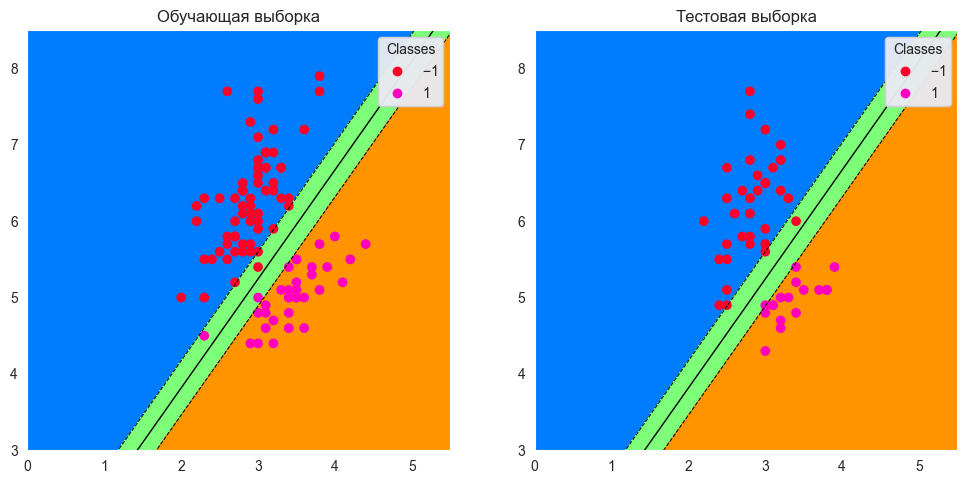

In [394]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

w = svm_2.w 

xgrid, ygrid = np.meshgrid(x1, x2)
z = w[0] + w[2] * xgrid + w[1]*ygrid


# Обучающая выборка
fig = plt.figure(figsize=(12, 12))


ax = fig.add_subplot(221)
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")

ax.set_title('Обучающая выборка')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


#тестовая выборка
ax = fig.add_subplot(222)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")




legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)


plt.show()


## Третья модель

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=122)

In [396]:
svm_3 = SupportVectorMachine(X_train, y_train, min_iterations=10000)
svm_3.fit()  #веса

array([ 1.29495 , -1.992275,  3.05281 ])

Метрики для тренировочной выборки
accuracy: 0.99
precision: 1.0
recall: 0.9714285714285714
f1: 0.9855072463768116

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[65  0]
 [ 1 34]]


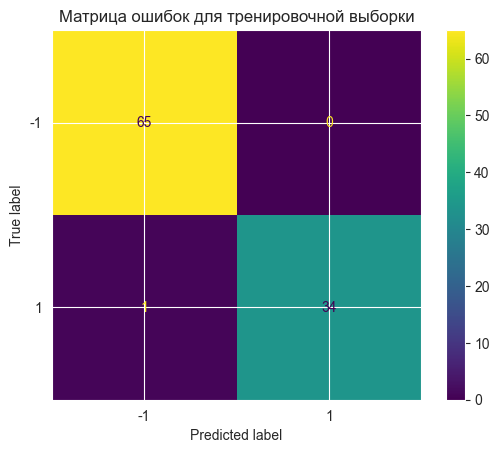

Матрица ошибок, полученная методом confusion_matrix
 [[35  0]
 [ 0 15]]


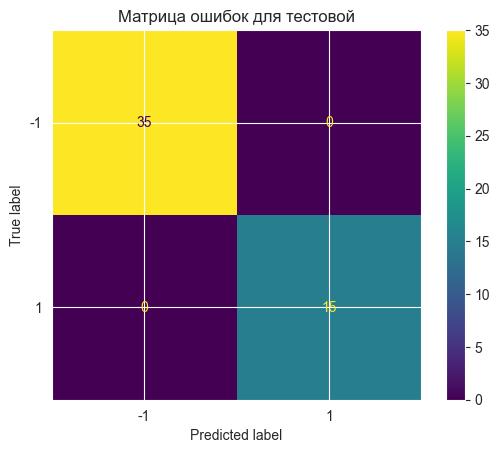

In [397]:

cntr_svm_3 = Counter(X_train, X_test, y_train, y_test, svm_3)
cntr_svm_3.try_model()

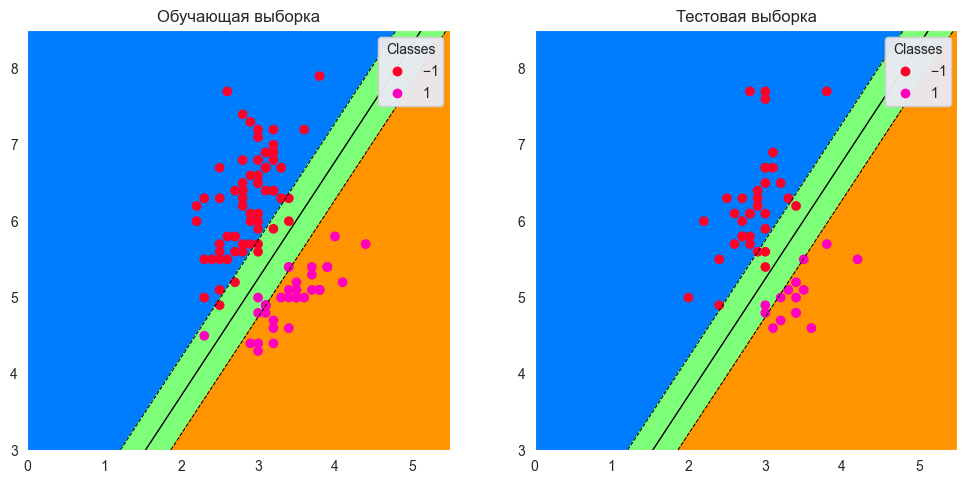

In [399]:

x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

w = svm_3.w 

xgrid, ygrid = np.meshgrid(x1, x2)
z = w[0] + w[2] * xgrid + w[1]*ygrid


# Обучающая выборка
fig = plt.figure(figsize=(12, 12))


ax = fig.add_subplot(221)
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")

ax.set_title('Обучающая выборка')


legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


#тестовая выборка
ax = fig.add_subplot(222)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)

scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")




legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.set_title('Тестовая выборка')
ax.add_artist(legend1)


plt.show()

# Задание 4
## Текст задания
Сравните итоги выполненных ранее трёх попыток обучения. Сделайте
выводы.

## Пояснения
По итогу независимо от разбиения последний объект никак не получается отделить в обучающей выборке(так получилось, то он попал во всех трех разбиениях в обучающую выборку. Однако на всех тестовых выборках метрики 1. Значит модель не переобучилась и имеет хорошую обобщающую способность. 

По итогу можно сказать что выборка линейно неразделима, либо с точки зрения линейной модели слишком сильно пострадает обобщающая способность если подстраиваться под одну точку. 

Визуально кажется, что выборка линейна неразделима, но так может показаться из-за масштаба, так что для более корректного вывода следует исследовать сами данные

# Задание 5




## Текст задания
Реализуйте задачу классификации с квадратичной функцией SVM на
последнем наборе обучающей и тестовой выборок (также диаграммой
рассеяния и линией раздела).

## Пояснения по поводу svm
(тут должно быть про отображение из R^2 в R^5 и переход обратно для решения задачи линейной классификации)

In [400]:
class QuadraSupportVectorMachine(SupportVectorMachine):#наследуемся от градиентного спуска
    def init_r(self):
        self.width = 6 #переопределим количество признаков
        self.to_new_r() #переведем их в пятимерное пространство
        self.w = np.array([1, 1, 1, 1, 1, 1]) #зададим новые стартовые веса для этого пространства
    def to_new_r(self, X = None): #добавляем переход в пятимерное пространство для данных
        
        flag_ = True
        if X is None:
            flag_ = False
            X = self.X
        
        X =  np.concatenate((np.ones((len(X), 3)), X), axis=1) #фиктивная единица
        for i in range(len(X)):
            
            X[i, :] = np.array([1, X[i, -1]**2, X[i, -2]**2, X[i, -1], X[i, -2], X[i, -1] * X[i, -2]])
        if flag_:
            return X
        self.X = X
    
    
    def predict(self, X): #переопределение функции предсказания
        X =  np.concatenate((np.ones(len(X)).reshape(-1, 1), X), axis=1) #фиктивная единица
        X = self.to_new_r(X) #перевод в новое пространство данных
        return np.sign(np.dot(X, self.w).reshape(-1, 1)) #предсказание
        
    

## Решение

Используем последнее разбиение для обучения новой модели

In [401]:
qsvm = QuadraSupportVectorMachine(X_train, y_train, h=0.0005, min_iterations=30000) #инициализация метода
qsvm.init_r() #для перехода в новое пространство

In [402]:
qsvm.fit()

array([ 1.9635  ,  0.828125, -1.295475,  2.12185 ,  3.04705 ,  0.222165])

### Уравнение разделяющей гиперплоскости
напишу потом

### Метрики

Метрики для тренировочной выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0

Метрики для тестовой выборки
accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
Матрица ошибок, полученная методом confusion_matrix
 [[65  0]
 [ 0 35]]


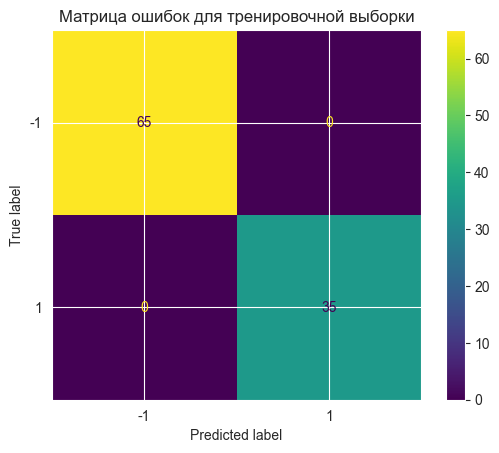

Матрица ошибок, полученная методом confusion_matrix
 [[35  0]
 [ 0 15]]


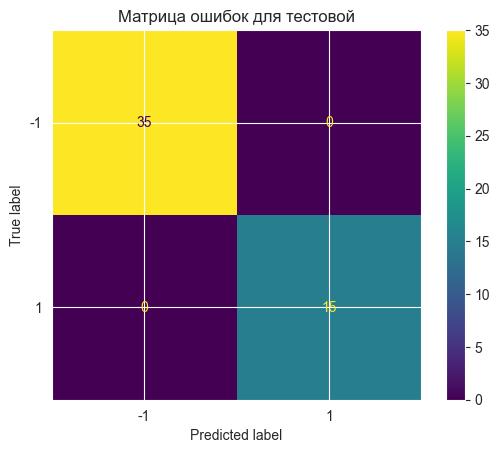

In [403]:
cntr_qsvm = Counter(X_train, X_test, y_train, y_test, qsvm)
cntr_qsvm.try_model()

### Линии уровня гиперплоскости

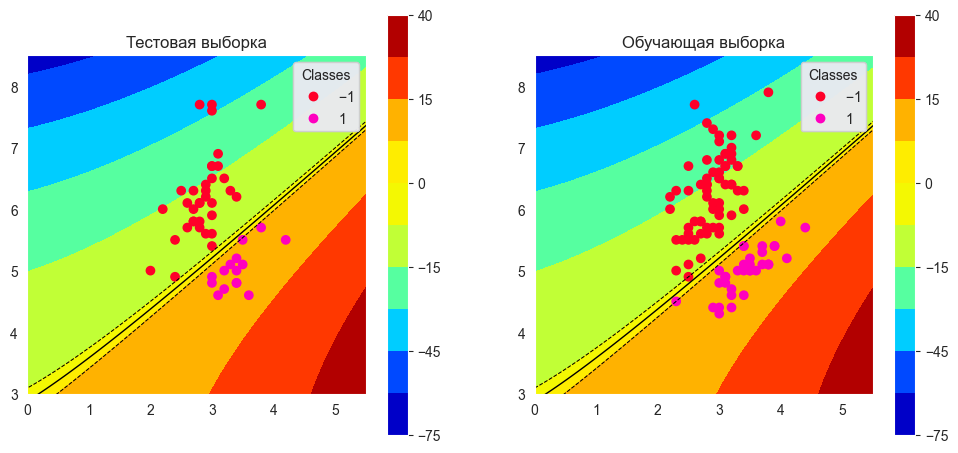

In [404]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)

w = qsvm.w  
z = w[0] + w[1]*xgrid**2 + w[2]*ygrid**2 + w[3]*xgrid + w[4]*ygrid + w[5]*xgrid*ygrid 

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_test, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('Тестовая выборка')
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")

ax = fig.add_subplot(222)


plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap="gist_rainbow", marker="o")
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Обучающая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


plt.show()

## Выводы по svm с квадратичным ядром

Квадратичное ядро даже смогло описать ту точку с которой не справилась линейная svm. Сложно сказать переобучение это или такая природа предметной области. Мы удалили два признака, потому какие-то выводы сложно делать исходя из визуальных данных


# Задание 6

## Текст задания
Сравните точность классификации на тестовой выборке с линейной SVM.
Объясните результат.


## Решение
Точность классификации отличается, казалось бы, несильно, однако точность 1 и любая меньше 1 - абсолютно разные результаты. 

В обобщающей способности линейного классификатора нет сомнений поскольку это самая простая модель, за исключением константной, которая только может быть. 

Однако квадратичная могла и сильно подстроиться под ту одну точку, хотя в реальных данных там может оказаться много точек другого класса.

Может оказаться так, что все-таки там природно розовые точки, потому можно сделать вывод, что обе модели хорошо справились со своей задачей

# Задание 7
## Текст задания
Определите сорт 20 объектов из дополнительной выборки (файл «Dop.csv»).
Качество определения сорта проверит преподаватель.

## Пояснение перед решением

Для предсказания будем использовать две модели, чтобы визуально посмотреть насколько повлияли "выбросы" на предсказание модели в финальной тестовой выборки(мы не знаем ответы)

## Решение

In [405]:
df_dop = pd.read_csv("data/Dop.csv") ## чтение датасета
df_dop.head()

,Sepal.L,Sepal.W,Petal.L,Petal.W
0,6.0,2.9,4.9,1.6
1,5.2,3.0,2.4,0.5
2,5.7,2.8,4.5,1.4
3,5.4,3.4,2.3,0.9
4,6.7,3.3,5.4,2.0


In [406]:
y_dop = pd.DataFrame()
X_dop = df_dop[["Sepal.L", "Sepal.W"]].to_numpy() #отбираем нужные признаки


In [407]:
y_pred_qsvm_dop = qsvm.predict(X_dop)
y_pred_svm_dop = svm_3.predict(X_dop)




## Ответы

In [408]:
print(*y_pred_qsvm_dop.reshape(1, -1)) #Ответы по модели с квадратичным ядром

[-1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1. -1.
 -1. -1.]


In [409]:
print(*y_pred_svm_dop.reshape(1, -1)) # Ответы по линейной модели

[-1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1.
 -1. -1.]


In [410]:
print(y_pred_svm_dop.reshape(1, -1) == y_pred_qsvm_dop.reshape(1, -1) ) #посмотрим одинаковое ли предсказание


[[ True  True  True  True  True  True  True  True  True  True  True  True
  False  True  True  True  True  True  True  True]]


### Пояснение к ответам
Скорее всего можно сказать, что мы гарантировали точность модели 0.95 на финальной тестовой выборке, поскольку у двух хороших моделей 95 процентов ответов совпали



##  Визуализация ответов

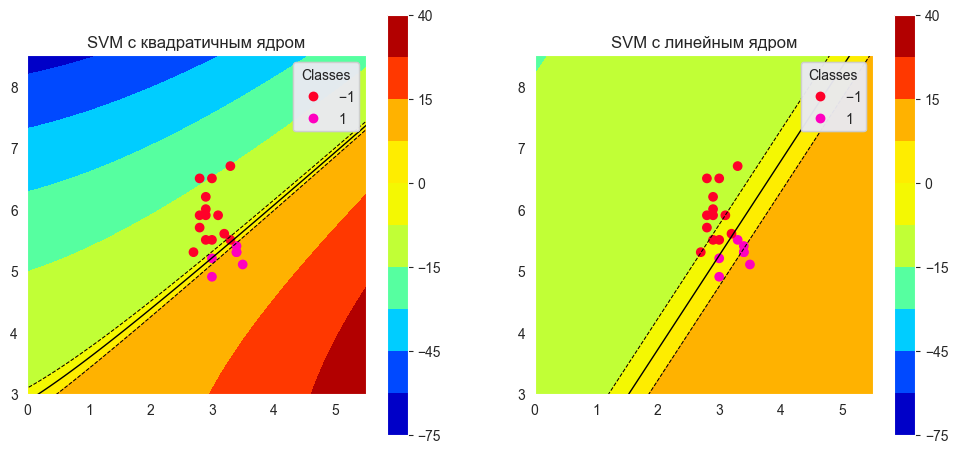

In [411]:
x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)


xgrid, ygrid = np.meshgrid(x1, x2)

w = qsvm.w  
z = w[0] + w[1]*xgrid**2 + w[2]*ygrid**2 + w[3]*xgrid + w[4]*ygrid + w[5]*xgrid*ygrid 

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_dop[:, 1], X_dop[:, 0], c=y_pred_qsvm_dop, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('SVM с квадратичным ядром')
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

ax = fig.add_subplot(222)
w = svm_3.w 
z = w[0] + w[2] * xgrid + w[1]*ygrid

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_dop[:, 1], X_dop[:, 0], c=y_pred_svm_dop, cmap="gist_rainbow", marker="o")
plt.xlim(0, 5.5)
plt.ylim(3, 8.5)
ax.set_aspect('equal', adjustable='box')
ax.set_title('SVM с линейным ядром')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)


plt.show()

### Пояснение к визуализации

Можно сказать, что на ответ повлияла та точка, поскольку сильно оттянулась кривая. Однако гипотетическая точность у обоих моделей все равно очень хорошая

# Дополнительно

# Задание 1
## Текст задания
Реализуйте нелинейную SVM с гауссовой или сигмоидальной
функцией ядра. Сравните результаты с предыдущими вариантами
классификации +3 балла.

## Решение 
пока скипну

# Задание 2
## Текст задания

Найдите датасет с 50+ объектами с 2-мя числовыми признаками (или
сгенерируйте датасет программно с интерпретацией признаков с
100+ объектами), для которого линейная классификация SVM
достаточно проблемна,
а квадратичная даёт качественные
результаты. Покажите это практическими расчётами +2 балла.

## Пояснения
Нарисуем две окружности с одним центром, но разными радиусами, тогда svm с квадратичным ядром разделит две выборки, а линейное не сможет


In [412]:
from sklearn.datasets import make_circles

In [413]:
X_blob, y_blob =  make_circles(
    n_samples=150, factor=0.5, noise=0.05, random_state=170
)


In [414]:
y_blob = pd.DataFrame(y_blob)
y_blob

,0
0,0
1,1
2,1
3,0
4,0
...,...
145,0
146,0
147,0
148,0


In [415]:
y_blob[0] = y_blob[0].apply(lambda x: x - int(x == 0))

In [416]:
y_blob = y_blob[0].to_numpy().reshape(-1, 1)


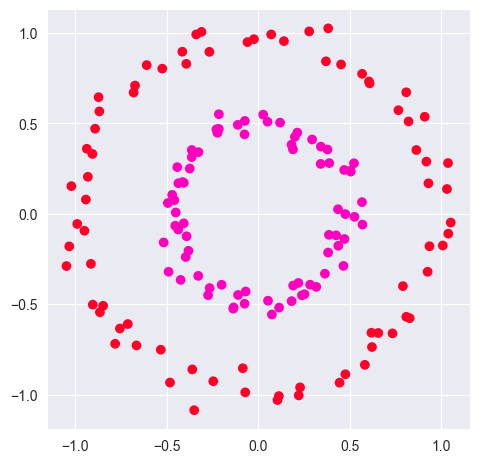

In [417]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)


scatter = ax.scatter(X_blob[:, 1], X_blob[:, 0], c=y_blob, cmap="gist_rainbow", marker="o")

In [424]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.33, random_state=19)

In [419]:
blob_svm = SupportVectorMachine(X_blob_train, y_blob_train, h=0.0005, min_iterations=1000, logging=False)

In [420]:
blob_svm.fit()

array([-0.281     ,  0.71804937,  0.0459485 ])

In [421]:

blob_qsvm = QuadraSupportVectorMachine(X_blob_train, y_blob_train, h=0.0005, min_iterations=1000)
blob_qsvm.init_r()

In [422]:
blob_qsvm.fit()

array([ 1.968     , -3.3202778 , -3.45061363, -0.00893396,  0.0040487 ,
        0.05459168])

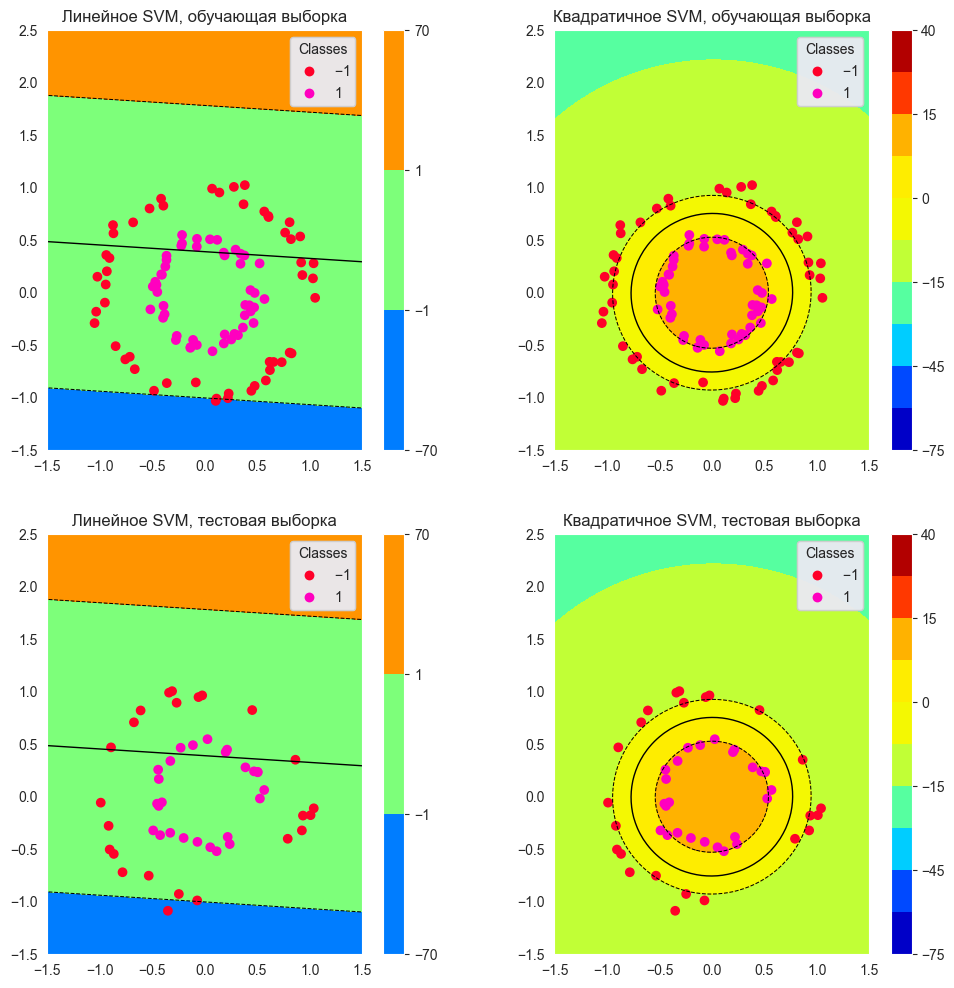

In [423]:

x1 = np.arange(-10, 15, 0.05)
x2 = np.arange(-10, 15, 0.05)

w = blob_svm.w 

xgrid, ygrid = np.meshgrid(x1, x2)
z = w[0] + w[2] * xgrid + w[1]*ygrid


# Обучающая выборка
fig = plt.figure(figsize=(12, 12))


ax = fig.add_subplot(223)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.colorbar()
scatter = ax.scatter(X_blob_test[:, 1], X_blob_test[:, 0], c=y_blob_test, cmap="gist_rainbow", marker="o")


plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Линейное SVM, тестовая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax = fig.add_subplot(221)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-70,-1, 1, 70], linestyles=["--", '-', '--'])
plt.colorbar()
scatter = ax.scatter(X_blob_train[:, 1], X_blob_train[:, 0], c=y_blob_train, cmap="gist_rainbow", marker="o")


plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Линейное SVM, обучающая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

w = blob_qsvm.w
z = w[0] + w[1]*xgrid**2 + w[2]*ygrid**2 + w[3]*xgrid + w[4]*ygrid + w[5]*xgrid*ygrid 


ax = fig.add_subplot(222)

plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40])
plt.colorbar()
plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
scatter = ax.scatter(X_blob_train[:, 1], X_blob_train[:, 0], c=y_blob_train, cmap="gist_rainbow", marker="o")
ax.set_aspect('equal', adjustable='box')
ax.set_title('Квадратичное SVM, обучающая выборка')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")


ax = fig.add_subplot(224)


plt.contour(x1, x2, z, colors="black", levels=[-1, 0, 1], linewidths=[0.75, 1, 0.75], linestyles=["--", '-', '--'])
plt.contourf(x1, x2, z, cmap="jet", levels=[-75, -60, -45, -30, -15, -1, 0, 1, 15, 30, 40], linestyles=["--", '-', '--'])
plt.colorbar()
scatter = ax.scatter(X_blob_test[:, 1], X_blob_test[:, 0], c=y_blob_test, cmap="gist_rainbow", marker="o")


plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 2.5)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Квадратичное SVM, тестовая выборка')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
